# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                 
Sample_203  Q9H4D0                            16.097
Sample_185  Q9Y617                            15.069
Sample_135  O95206;O95206-2                   16.219
Sample_202  B4DYV8;Q8WZ75;Q8WZ75-2;Q8WZ75-3   14.550
Sample_181  Q9Y279;Q9Y279-2                   16.246
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups                            
Sample_040  A0A087WSY4                                   16.001
Sample_020  P05556;P05556-2;P05556-3;P05556-4;P05556-5   13.860
Sample_033  Q5VWW1                                       15.418
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.622
            A0A075B6Q5                 12.427
            A0A075B6R2                 12.437
            A0A075B6S5                 12.487
            A0A087WSY4                 13.385
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   11.724
            Q9UI40;Q9UI40-2            13.540
            Q9UIW2                     13.879
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.379
            Q9UP79                     13.151
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.232,15.050,16.842,19.863,15.841,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.801,19.067,...,15.528,15.576,14.126,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.943,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.471,17.705,17.039,15.968,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.552,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.379,15.345,17.084,18.708,14.249,19.433,11.118,11.019
Sample_207,15.739,16.877,15.469,16.898,14.979,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,11.542,12.936,13.643,12.217,10.797,12.412,13.956,12.206,12.925,11.843
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.477,19.067,16.127,...,11.230,13.007,13.723,12.561,13.495,12.770,13.005,12.891,12.147,13.104
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,13.195,13.054,13.949,12.461,11.884,12.525,12.797,13.358,13.021,14.748
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,11.801,13.473,13.383,12.139,13.111,12.426,13.550,13.829,13.992,12.355
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,13.155,13.133,13.942,13.080,13.195,11.438,12.102,13.375,13.322,11.276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,13.542,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 100.96it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.43it/s]

100%|██████████| 2/2 [00:00<00:00,  6.37it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.32it/s]

100%|██████████| 3/3 [00:00<00:00,  3.77it/s]

100%|██████████| 3/3 [00:00<00:00,  3.98it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.73it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.70it/s]

100%|██████████| 4/4 [00:00<00:00,  4.10it/s]

100%|██████████| 4/4 [00:00<00:00,  4.65it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.94it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.04it/s]

 80%|████████  | 4/5 [00:00<00:00,  3.62it/s]

100%|██████████| 5/5 [00:01<00:00,  2.94it/s]

100%|██████████| 5/5 [00:01<00:00,  3.48it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  8.35it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.55it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  3.64it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.20it/s]

100%|██████████| 6/6 [00:01<00:00,  2.70it/s]

100%|██████████| 6/6 [00:01<00:00,  3.26it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.88it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.92it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  5.24it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  4.82it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.93it/s]

100%|██████████| 7/7 [00:01<00:00,  3.32it/s]

100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.67it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.04it/s]

 50%|█████     | 4/8 [00:00<00:01,  3.86it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.57it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.58it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.41it/s]

100%|██████████| 8/8 [00:02<00:00,  2.88it/s]

100%|██████████| 8/8 [00:02<00:00,  3.48it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.72it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.11it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.35it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.93it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.99it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.80it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.44it/s]

100%|██████████| 9/9 [00:02<00:00,  3.19it/s]

100%|██████████| 9/9 [00:02<00:00,  3.75it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  8.03it/s]

 30%|███       | 3/10 [00:00<00:01,  5.58it/s]

 40%|████      | 4/10 [00:00<00:01,  4.71it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.51it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.26it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.27it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.11it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.66it/s]

100%|██████████| 10/10 [00:02<00:00,  3.11it/s]

100%|██████████| 10/10 [00:02<00:00,  3.93it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.28it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.12it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.55it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.34it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.39it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.37it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.17it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  4.09it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.38it/s]

100%|██████████| 11/11 [00:02<00:00,  3.08it/s]

100%|██████████| 11/11 [00:02<00:00,  3.87it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  8.55it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.31it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.24it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.11it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.13it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.06it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.17it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  4.36it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.34it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.31it/s]

100%|██████████| 12/12 [00:02<00:00,  4.29it/s]

100%|██████████| 12/12 [00:02<00:00,  4.40it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  7.75it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.22it/s]

 31%|███       | 4/13 [00:00<00:02,  4.02it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.92it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.85it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.99it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.23it/s]

 69%|██████▉   | 9/13 [00:02<00:00,  4.25it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  4.22it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.18it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  4.12it/s]

100%|██████████| 13/13 [00:03<00:00,  3.95it/s]

100%|██████████| 13/13 [00:03<00:00,  4.15it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.65it/s]

 21%|██▏       | 3/14 [00:00<00:02,  5.17it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.71it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.82it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.89it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.85it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  3.71it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.72it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.83it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.87it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  3.90it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.55it/s]

100%|██████████| 14/14 [00:03<00:00,  3.36it/s]

100%|██████████| 14/14 [00:03<00:00,  3.83it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.76it/s]

 20%|██        | 3/15 [00:00<00:02,  5.14it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.31it/s]

 33%|███▎      | 5/15 [00:01<00:02,  4.05it/s]

 40%|████      | 6/15 [00:01<00:02,  4.13it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.94it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  3.89it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.60it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.60it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  3.58it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.60it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.70it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.90it/s]

100%|██████████| 15/15 [00:03<00:00,  3.71it/s]

100%|██████████| 15/15 [00:03<00:00,  3.92it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.002      0.062 0.024          0.650 0.423       0.088   
2             0.005 0.003      0.054 0.024          0.814 0.083       0.726   
3             0.006 0.003      0.068 0.027          0.800 0.077       0.719   
4             0.006 0.002      0.065 0.020          0.806 0.088       0.786   
5             0.005 0.002      0.052 0.021          0.816 0.092       0.785   
6             0.006 0.004      0.064 0.027          0.816 0.094       0.757   
7             0.006 0.003      0.061 0.021          0.810 0.089       0.756   
8             0.005 0.003      0.058 0.022          0.795 0.090       0.754   
9             0.006 0.003      0.057 0.022          0.794 0.079       0.830   
10            0.005 0.002      0.048 0.018          0.792 0.078       0.826   
11            0.005 0.002      0.046 0.016          0.788 0.084       0.825   
12            0.006 0.003      0.060 0.022          0.808 0.080       0.855   
13            0.006 0.003      0.057 0.022          0.822 0.077       0.853   
14            0.005 0.002      0.050 0.016          0.817 0.084       0.832   
15            0.006 0.002      0.055 0.019          0.813 0.084       0.831   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.082   0.149 0.126                  0.537 0.039        0.856   
2          0.125   0.762 0.090                  0.802 0.067        0.868   
3          0.122   0.752 0.087                  0.794 0.067        0.869   
4          0.116   0.791 0.086                  0.823 0.071        0.882   
5          0.115   0.796 0.086                  0.827 0.070        0.883   
6          0.117   0.780 0.088                  0.815 0.071        0.886   
7          0.114   0.777 0.085                  0.812 0.067        0.885   
8          0.110   0.769 0.085                  0.805 0.068        0.886   
9          0.105   0.807 0.072                  0.835 0.061        0.910   
10         0.108   0.804 0.072                  0.833 0.061        0.907   
11         0.114   0.801 0.079                  0.830 0.066        0.907   
12         0.090   0.827 0.066                  0.852 0.058        0.918   
13         0.089   0.833 0.063                  0.857 0.055        0.918   
14         0.101   0.821 0.073                  0.847 0.063        0.915   
15         0.101   0.818 0.073                  0.844 0.063        0.913   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.058                  0.825 0.085        210.000 0.000  
2          0.061                  0.853 0.073        210.000 0.000  
3          0.057                  0.856 0.065        210.000 0.000  
4          0.064                  0.876 0.066        210.000 0.000  
5          0.061                  0.876 0.064        210.000 0.000  
6          0.059                  0.876 0.065        210.000 0.000  
7          0.059                  0.875 0.065        210.000 0.000  
8          0.061                  0.876 0.065        210.000 0.000  
9          0.051                  0.897 0.054        210.000 0.000  
10         0.052                  0.893 0.054        210.000 0.000  
11         0.051                  0.895 0.053        210.000 0.000  
12         0.049                  0.909 0.051        210.000 0.000  
13         0.048                  0.906 0.051        210.000 0.000  
14         0.048                  0.901 0.052        210.000 0.000  
15         0.049                  0.900 0.053 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 345.15it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.41it/s]

100%|██████████| 2/2 [00:00<00:00,  7.37it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.51it/s]

100%|██████████| 3/3 [00:00<00:00,  3.89it/s]

100%|██████████| 3/3 [00:00<00:00,  4.12it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.71it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.27it/s]

100%|██████████| 4/4 [00:01<00:00,  2.57it/s]

100%|██████████| 4/4 [00:01<00:00,  2.87it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.90it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.85it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.22it/s]

100%|██████████| 5/5 [00:01<00:00,  2.84it/s]

100%|██████████| 5/5 [00:01<00:00,  3.25it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.13it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.72it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.19it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.92it/s]

100%|██████████| 6/6 [00:01<00:00,  3.38it/s]

100%|██████████| 6/6 [00:01<00:00,  3.86it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.45it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.18it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.47it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.09it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.82it/s]

100%|██████████| 7/7 [00:01<00:00,  3.25it/s]

100%|██████████| 7/7 [00:01<00:00,  3.88it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.37it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.85it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.38it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.17it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.11it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.03it/s]

100%|██████████| 8/8 [00:01<00:00,  4.09it/s]

100%|██████████| 8/8 [00:01<00:00,  4.33it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.37it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.03it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.68it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.67it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.92it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  3.11it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.21it/s]

100%|██████████| 9/9 [00:02<00:00,  3.34it/s]

100%|██████████| 9/9 [00:02<00:00,  3.13it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.44it/s]

 30%|███       | 3/10 [00:00<00:01,  5.26it/s]

 40%|████      | 4/10 [00:00<00:01,  4.54it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.09it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.71it/s]

 70%|███████   | 7/10 [00:01<00:01,  3.00it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.64it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.46it/s]

100%|██████████| 10/10 [00:03<00:00,  2.19it/s]

100%|██████████| 10/10 [00:03<00:00,  2.94it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.37it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.07it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.01it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.89it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.76it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.65it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.47it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  2.86it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.62it/s]

100%|██████████| 11/11 [00:03<00:00,  2.29it/s]

100%|██████████| 11/11 [00:03<00:00,  3.03it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.43it/s]

 25%|██▌       | 3/12 [00:00<00:01,  4.69it/s]

 33%|███▎      | 4/12 [00:00<00:02,  3.50it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.89it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.60it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.55it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.65it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.69it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.48it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.37it/s]

100%|██████████| 12/12 [00:04<00:00,  2.25it/s]

100%|██████████| 12/12 [00:04<00:00,  2.68it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.42it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.40it/s]

 31%|███       | 4/13 [00:01<00:02,  3.44it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.36it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.17it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.27it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.30it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.33it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.88it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.69it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.58it/s]

100%|██████████| 13/13 [00:04<00:00,  2.54it/s]

100%|██████████| 13/13 [00:04<00:00,  3.03it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.91it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.90it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.30it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.78it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.64it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.65it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.59it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.13it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  2.68it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.32it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.12it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.09it/s]

100%|██████████| 14/14 [00:05<00:00,  2.02it/s]

100%|██████████| 14/14 [00:05<00:00,  2.75it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  6.12it/s]

 20%|██        | 3/15 [00:00<00:02,  4.88it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.84it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.58it/s]

 40%|████      | 6/15 [00:02<00:03,  2.53it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.50it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.64it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.87it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.83it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.97it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.86it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.87it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.08it/s]

100%|██████████| 15/15 [00:05<00:00,  2.91it/s]

100%|██████████| 15/15 [00:05<00:00,  2.93it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.003      0.057 0.024          0.000 0.000       0.000   
2             0.007 0.005      0.069 0.027          0.773 0.114       0.609   
3             0.007 0.003      0.072 0.026          0.717 0.116       0.619   
4             0.005 0.003      0.053 0.022          0.703 0.115       0.607   
5             0.004 0.001      0.045 0.012          0.694 0.112       0.602   
6             0.006 0.002      0.059 0.020          0.706 0.109       0.607   
7             0.005 0.002      0.050 0.018          0.695 0.099       0.632   
8             0.007 0.003      0.068 0.025          0.719 0.096       0.668   
9             0.007 0.004      0.071 0.021          0.700 0.094       0.646   
10            0.006 0.003      0.062 0.022          0.766 0.091       0.789   
11            0.006 0.003      0.061 0.026          0.762 0.083       0.791   
12            0.005 0.002      0.047 0.014          0.759 0.085       0.782   
13            0.006 0.004      0.061 0.025          0.765 0.086       0.789   
14            0.005 0.002      0.050 0.016          0.770 0.084       0.784   
15            0.004 0.001      0.041 0.012          0.766 0.087       0.774   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.496 0.008        0.857   
2          0.131   0.672 0.100                  0.736 0.071        0.781   
3          0.129   0.656 0.102                  0.717 0.077        0.788   
4          0.135   0.642 0.105                  0.706 0.079        0.782   
5          0.127   0.636 0.099                  0.700 0.074        0.780   
6          0.127   0.643 0.091                  0.707 0.067        0.781   
7          0.128   0.654 0.093                  0.712 0.071        0.797   
8          0.125   0.686 0.092                  0.737 0.072        0.804   
9          0.129   0.664 0.094                  0.720 0.072        0.806   
10         0.121   0.772 0.085                  0.805 0.072        0.885   
11         0.126   0.771 0.085                  0.805 0.071        0.890   
12         0.122   0.766 0.083                  0.800 0.070        0.890   
13         0.123   0.771 0.080                  0.804 0.067        0.890   
14         0.123   0.770 0.080                  0.805 0.066        0.890   
15         0.130   0.763 0.084                  0.799 0.070        0.887   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.828 0.087        210.000 0.000  
2          0.075                  0.730 0.095        210.000 0.000  
3          0.072                  0.739 0.093        210.000 0.000  
4          0.077                  0.725 0.097        210.000 0.000  
5          0.077                  0.717 0.099        210.000 0.000  
6          0.076                  0.716 0.099        210.000 0.000  
7          0.068                  0.755 0.090        210.000 0.000  
8          0.069                  0.756 0.091        210.000 0.000  
9          0.070                  0.754 0.090        210.000 0.000  
10         0.055                  0.861 0.063        210.000 0.000  
11         0.054                  0.867 0.062        210.000 0.000  
12         0.053                  0.868 0.062        210.000 0.000  
13         0.053                  0.865 0.064        210.000 0.000  
14         0.053                  0.865 0.064        210.000 0.000  
15         0.053                  0.861 0.065 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 954.77it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 31.27it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 22.35it/s]

100%|██████████| 3/3 [00:00<00:00, 21.90it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 18.41it/s]

100%|██████████| 4/4 [00:00<00:00, 14.04it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 20.69it/s]

100%|██████████| 5/5 [00:00<00:00, 18.62it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 19.69it/s]

 67%|██████▋   | 4/6 [00:00<00:00, 15.26it/s]

100%|██████████| 6/6 [00:00<00:00, 12.67it/s]

100%|██████████| 6/6 [00:00<00:00, 13.48it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 22.33it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 15.28it/s]

100%|██████████| 7/7 [00:00<00:00, 16.01it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 17.31it/s]

 50%|█████     | 4/8 [00:00<00:00, 12.03it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 12.29it/s]

100%|██████████| 8/8 [00:00<00:00, 11.80it/s]

100%|██████████| 8/8 [00:00<00:00, 12.16it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 19.42it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 16.36it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 15.88it/s]

100%|██████████| 9/9 [00:00<00:00, 16.13it/s]

100%|██████████| 9/9 [00:00<00:00, 16.38it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 17.14it/s]

 50%|█████     | 5/10 [00:00<00:00, 11.92it/s]

 70%|███████   | 7/10 [00:00<00:00, 11.84it/s]

 90%|█████████ | 9/10 [00:00<00:00, 11.24it/s]

100%|██████████| 10/10 [00:00<00:00, 12.10it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 26.43it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 24.12it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 16.88it/s]

100%|██████████| 11/11 [00:00<00:00, 19.02it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 33%|███▎      | 4/12 [00:00<00:00, 24.13it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 15.10it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 13.97it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 13.21it/s]

100%|██████████| 12/12 [00:00<00:00, 13.60it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 18.02it/s]

 38%|███▊      | 5/13 [00:00<00:00, 16.98it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 16.84it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 15.72it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 13.13it/s]

100%|██████████| 13/13 [00:00<00:00, 11.79it/s]

100%|██████████| 13/13 [00:00<00:00, 13.56it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 22.31it/s]

 43%|████▎     | 6/14 [00:00<00:00, 16.64it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 16.32it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 14.93it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 14.98it/s]

100%|██████████| 14/14 [00:00<00:00, 15.38it/s]

100%|██████████| 14/14 [00:00<00:00, 15.78it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 19.72it/s]

 33%|███▎      | 5/15 [00:00<00:00, 16.38it/s]

 47%|████▋     | 7/15 [00:00<00:00, 16.03it/s]

 60%|██████    | 9/15 [00:00<00:00, 16.78it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 16.20it/s]

 87%|████████▋ | 13/15 [00:00<00:00, 16.11it/s]

100%|██████████| 15/15 [00:00<00:00, 15.85it/s]

100%|██████████| 15/15 [00:00<00:00, 16.23it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.049 0.018          0.000 0.000       0.000   
2             0.003 0.002      0.035 0.017          0.674 0.115       0.470   
3             0.004 0.001      0.046 0.014          0.610 0.128       0.445   
4             0.004 0.001      0.043 0.013          0.656 0.105       0.569   
5             0.005 0.002      0.049 0.017          0.669 0.105       0.586   
6             0.004 0.002      0.044 0.014          0.683 0.093       0.596   
7             0.005 0.002      0.048 0.019          0.676 0.097       0.598   
8             0.004 0.001      0.046 0.016          0.678 0.098       0.603   
9             0.004 0.002      0.045 0.015          0.661 0.101       0.614   
10            0.005 0.002      0.045 0.015          0.675 0.098       0.627   
11            0.002 0.001      0.024 0.005          0.672 0.100       0.616   
12            0.005 0.002      0.045 0.017          0.679 0.101       0.621   
13            0.005 0.003      0.049 0.021          0.677 0.096       0.617   
14            0.006 0.003      0.056 0.025          0.683 0.101       0.630   
15            0.008 0.004      0.070 0.030          0.676 0.106       0.618   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.736   
2          0.105   0.542 0.085                  0.645 0.055        0.662   
3          0.095   0.505 0.080                  0.612 0.060        0.655   
4          0.113   0.602 0.091                  0.672 0.068        0.756   
5          0.115   0.617 0.086                  0.683 0.068        0.778   
6          0.115   0.627 0.078                  0.692 0.058        0.781   
7          0.106   0.628 0.078                  0.691 0.061        0.800   
8          0.104   0.630 0.075                  0.692 0.058        0.800   
9          0.116   0.629 0.084                  0.689 0.066        0.802   
10         0.113   0.643 0.083                  0.700 0.066        0.801   
11         0.115   0.636 0.087                  0.695 0.067        0.798   
12         0.121   0.641 0.089                  0.700 0.070        0.803   
13         0.116   0.639 0.084                  0.699 0.067        0.801   
14         0.111   0.649 0.083                  0.705 0.066        0.802   
15         0.120   0.638 0.091                  0.698 0.070        0.798   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.068                  0.684 0.086        210.000 0.000  
2          0.076                  0.662 0.076        210.000 0.000  
3          0.071                  0.658 0.063        210.000 0.000  
4          0.067                  0.717 0.076        210.000 0.000  
5          0.063                  0.740 0.076        210.000 0.000  
6          0.059                  0.743 0.070        210.000 0.000  
7          0.061                  0.756 0.078        210.000 0.000  
8          0.063                  0.756 0.080        210.000 0.000  
9          0.065                  0.758 0.082        210.000 0.000  
10         0.068                  0.755 0.086        210.000 0.000  
11         0.069                  0.752 0.087        210.000 0.000  
12         0.065                  0.757 0.083        210.000 0.000  
13         0.065                  0.753 0.081        210.000 0.000  
14         0.062                  0.757 0.080        210.000 0.000  
15         0.062                  0.754 0.078 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,3,9,15
score_time,3,3,15
test_precision,13,2,14
test_recall,12,11,14
test_f1,13,10,14
test_balanced_accuracy,13,10,14
test_roc_auc,12,12,12
test_average_precision,12,12,9
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  3.74it/s]

 25%|██▌       | 3/12 [00:01<00:03,  2.77it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.43it/s]

 42%|████▏     | 5/12 [00:02<00:03,  2.30it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.44it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.56it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.79it/s]

 75%|███████▌  | 9/12 [00:03<00:00,  3.03it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.89it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.77it/s]

100%|██████████| 12/12 [00:04<00:00,  2.65it/s]

100%|██████████| 12/12 [00:04<00:00,  2.69it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 18.78it/s]

 42%|████▏     | 5/12 [00:00<00:00, 15.42it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 14.64it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 13.36it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 13.50it/s]

100%|██████████| 12/12 [00:00<00:00, 13.74it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.84it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.44it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.07it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.10it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.38it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  3.47it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.57it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.56it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.69it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.78it/s]

100%|██████████| 12/12 [00:03<00:00,  3.92it/s]

100%|██████████| 12/12 [00:03<00:00,  3.62it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


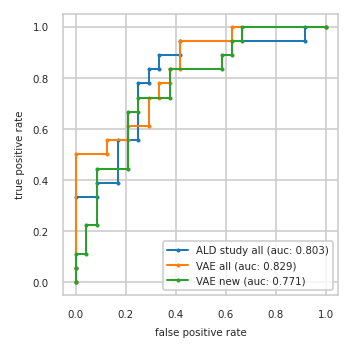

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.000 0.056
2          0.000 0.333   0.000 0.500   0.000 0.111
3          0.083 0.333   0.125 0.500   0.042 0.111
4          0.083 0.389   0.125 0.556   0.042 0.222
5          0.167 0.389   0.208 0.556   0.083 0.222
6          0.167 0.556   0.208 0.611   0.083 0.444
7          0.250 0.556   0.292 0.611   0.208 0.444
8          0.250 0.778   0.292 0.722   0.208 0.667
9          0.292 0.778   0.333 0.722   0.250 0.667
10         0.292 0.833   0.333 0.778   0.250 0.722
11         0.333 0.833   0.375 0.778   0.375 0.722
12         0.333 0.889   0.375 0.833   0.375 0.833
13         0.417 0.889   0.417 0.833   0.583 0.833
14         0.417 0.944   0.417 0.944   0.583 0.889
15         0.917 0.944   0.625 0.944   0.625 0.889
16         0.917 1.000   0.625 1.000   0.625 0.944
17         1.000 1.000   1.000 1.000   0.667 0.944
18           NaN   NaN     NaN   NaN   0.667 1.000
19           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,P02766,P01011,Q96MU8;Q96MU8-2;Q96MU8-3
2,A0A087WVV2;A0A0A0MRV0;Q9P2E9;Q9P2E9-2;V9GY78,P08670,P51688
3,P61981,Q9Y2T3;Q9Y2T3-3,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
4,P04075,P61981,Q9NUQ9
5,P14174,P15151-2,P31321
6,Q9Y2T3;Q9Y2T3-3,P04075,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
7,P00338;P00338-3,P14174,J3KSJ8;Q9UD71;Q9UD71-2
8,P25189;P25189-2,Q14894,Q96GD0


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


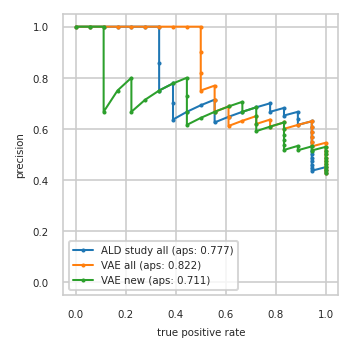

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.436 0.944     0.462 1.000     0.462 1.000
4          0.447 0.944     0.474 1.000     0.474 1.000
5          0.459 0.944     0.486 1.000     0.486 1.000
6          0.472 0.944     0.500 1.000     0.500 1.000
7          0.486 0.944     0.514 1.000     0.514 1.000
8          0.500 0.944     0.529 1.000     0.529 1.000
9          0.515 0.944     0.545 1.000     0.515 0.944
10         0.531 0.944     0.531 0.944     0.531 0.944
11         0.548 0.944     0.548 0.944     0.516 0.889
12         0.567 0.944     0.567 0.944     0.533 0.889
13         0.586 0.944     0.586 0.944     0.517 0.833
14         0.607 0.944     0.607 0.944     0.536 0.833
15         0.630 0.944     0.630 0.944     0.556 0.833
16         0.615 0.889     0.615 0.889     0.577 0.833
17         0.640 0.889     0.600 0.833     0.600 0.833
18         0.667 0.889     0.625 0.833     0.625 0.833
19         0.652 0.833     0.609 0.778     0.609 0.778
20         0.682 0.833     0.636 0.778     0.591 0.722
21         0.667 0.778     0.619 0.722     0.619 0.722
22         0.700 0.778     0.650 0.722     0.650 0.722
23         0.684 0.722     0.632 0.667     0.684 0.722
24         0.667 0.667     0.611 0.611     0.667 0.667
25         0.647 0.611     0.647 0.611     0.706 0.667
26         0.625 0.556     0.688 0.611     0.688 0.611
27         0.667 0.556     0.667 0.556     0.667 0.556
28         0.714 0.556     0.714 0.556     0.643 0.500
29         0.692 0.500     0.769 0.556     0.615 0.444
30         0.667 0.444     0.750 0.500     0.667 0.444
31         0.636 0.389     0.818 0.500     0.727 0.444
32         0.700 0.389     0.900 0.500     0.800 0.444
33         0.778 0.389     1.000 0.500     0.778 0.389
34         0.750 0.333     1.000 0.444     0.750 0.333
35         0.857 0.333     1.000 0.389     0.714 0.278
36         1.000 0.333     1.000 0.333     0.667 0.222
37         1.000 0.278     1.000 0.278     0.800 0.222
38         1.000 0.222     1.000 0.222     0.750 0.167
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     1.000 0.111
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


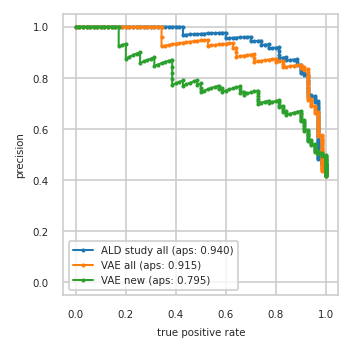

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


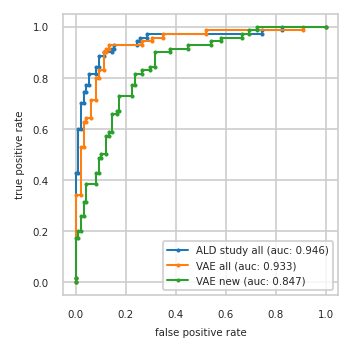

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}